### Background

Tests were run using the npm loadtest module like so:


`loadtest -c 200 --rps 200 -n 60000 -m POST http://35.231.236.14/api/v1/gfw-pro/polyIntersect/dissolve -p payload.json -T application/json`

The above tests sends 200 requests per second to the dissolve endpoint, using a simple single-feature geojson feature collection as a test. The tests sends 60,000 requests in total, for an overall time of 5 minutes. All tests, regardless of request rate, were run for a total of five minutes.

Load tests were run on an AWS server, and sent directly to the polyIntersect microservice, without going through the API gateway. The intent of these test was to evaluate any limitation caused by the CPU requirements of the dissolve functionality of the polyIntersect MS.

Metrics were collected using loadtest summary stats - a full log is available in dissolve-notes.txt. The geometry used is in the root directory as payload.json

#### Updated parameters for this test
This test is different than the one run on 2018-04-23 because of the horizonal pod autoscaler (HPA) config. The previous run had the number of pods for the `/dissolve` MS between 2 and 3. The values for this run are between 50 and 70, and the CPU allocated to each pod has been doubled from 100m to 200m (0.1 of a CPU vs 0.2).

Unlike previous tests, we did not test 1000 rps and 2000 rps benchmarks. Our goal for this test was to identify a combination of parameters that produced valid results for 500 rps. We're not quite there yet, but will continue to test.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('dissolve_results_50_to_70_CPU_200m.csv')

# calculate error percent
df['error_pct'] = (df.error_count / df.total_requests) * 100

# report mean latency in seconds, not milliseconds
df['mean_latency'] = df.mean_latency / 1000

df

,requests_per_second,peak_cpu,mean_latency,error_count,total_requests,error_pct
0,50,49,0.1534,0,15000.0,0.0
1,100,29,0.0465,0,30000.0,0.0
2,200,65,0.0488,0,60000.0,0.0
3,500,99,10.6303,150000,NaN,NaN


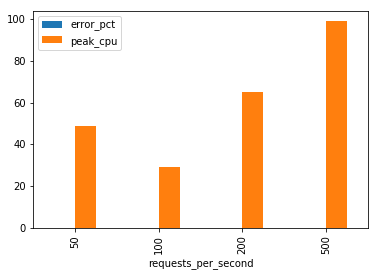

In [3]:
%matplotlib inline
df.plot(x="requests_per_second", y=["error_pct", "peak_cpu"], kind="bar")

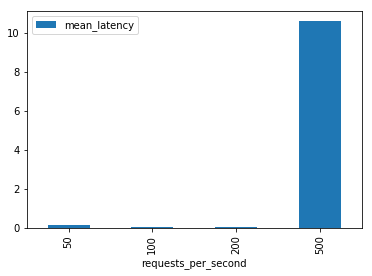

In [4]:
df.plot(x="requests_per_second", y="mean_latency", kind="bar")

#### Analysis

Compared to yesterday's run with the dissolve pods between 2 and 3, the 500 requests per second mean latency is much better. Yesterday's was 40 seconds, today's is 10.6 seconds. Not bad.

More work needs to be done to determine the minimum number of pods that we need ready at all times. Kube can certainly scale these pods, but if our work is to be done in 5 minute increments, it may not be able to scale it fast enough.

I'm also unsure when kube takes the minReplica parameter into account. I set it up 70 at one point, but we still only had 59 pods deployed. How does this work? To be continued . . . 